In [1]:
%load_ext autoreload
%autoreload 2

# ANALYSE EXPLORATOIRE DES DONNEES

In [2]:
import sys
'''
!"{sys.executable}" -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
'''

'\n!"{sys.executable}" -m pip install -U pandas-profiling[notebook]\n!jupyter nbextension enable --py widgetsnbextension\n'

In [3]:
#pip install ydata-profiling

In [4]:
# Standard Library Imports
from pathlib import Path

# Installed packages
import pandas as pd
from ipywidgets import widgets

# Our package
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

In [217]:
df= pd.read_csv("data/data.csv", sep=";")

In [218]:
df.head()

id_client job_category  service_channel nb_internet_products  \
0          1         8690              PRO                    2   
1          2         8690              PRO                    1   
2          3        7022Z  BUREAU DE POSTE                    1   
3          4        4399C  BUREAU DE POSTE                    0   
4          5        9609Z              PRO                    2   

   contract_type risk_of_credit      credit_flux annual_flux  target  
0              1              8  0 a 70% de flux    20903,81       0  
1              1              7  0 a 70% de flux      5192,5       0  
2              1              6      Pas de flux         NaN       0  
3              1           CESS  0 a 70% de flux        33,4       0  
4              1              7  0 a 70% de flux       13910       0

In [10]:
df.shape

(20830, 9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20830 entries, 0 to 20829
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_client             20830 non-null  int64 
 1   job_category          20018 non-null  object
 2   service_channel       20830 non-null  object
 3   nb_internet_products  20829 non-null  object
 4   contract_type         20830 non-null  int64 
 5   risk_of_credit        16063 non-null  object
 6   credit_flux           20829 non-null  object
 7   annual_flux           13346 non-null  object
 8   target                20830 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.4+ MB


In [12]:
df.isna().sum()

id_client                  0
job_category             812
service_channel            0
nb_internet_products       1
contract_type              0
risk_of_credit          4767
credit_flux                1
annual_flux             7484
target                     0
dtype: int64

Les colonnes 'credit_flux' et 'nb_internet_products' ont chacune une seule ligne avec des valeurs manquantes, donc je vais me simplifier la tâche et supprimer ces lignes. A l'oeil nu j'ai directement vu qu'il s'agissait des deux dernières lignes.

In [13]:
df.drop(df.tail(2).index,inplace = True)

In [15]:
# Generate the Profiling Report
profile = ProfileReport(
    df, title="Dataset", html={"style": {"full_width": True}}, sort=None
)

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

J'ai pensé à appliquer la fonction get_dummies() de pandas pour les variables categorielles mais je pense que le nombre de colonnes sera beaucoup plus grand (598+12+16+4=630). 

Je me base principalement sur les alertes et les correlations observées dans le rapport ci-dessus.

# DATA CLEANING

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1- Dans un premier temps, je supprime la colonne 'id_client' parcequ'elle n'ajoute aucune valeur au dataset.

In [17]:
df= df.drop(columns=["id_client"])

<Axes: >

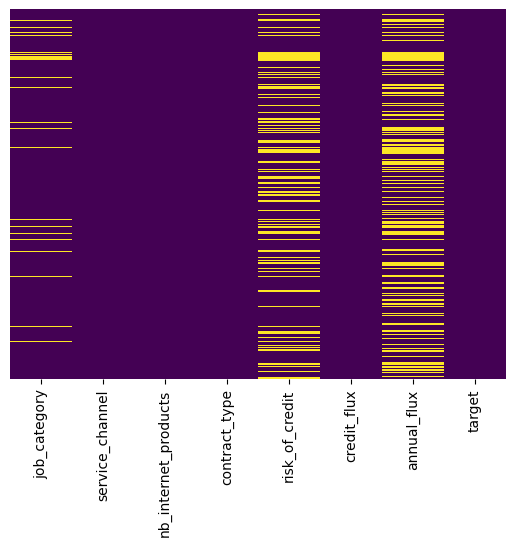

In [18]:
#missing values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

2- Comment gérer les valeurs manquantes?

In [19]:
x= df.loc[:, ['credit_flux', 'annual_flux']]

In [20]:
x1= x[x['annual_flux'].isna()]
x1.nunique()

credit_flux    1
annual_flux    0
dtype: int64

In [21]:
x2= x[x['credit_flux']=='Pas de flux']
x2.nunique()

credit_flux    1
annual_flux    0
dtype: int64

Pour la colonne 'annual_flux', on remarque qu'elle est vide lorsque la valeur dans la colonne 'credit_flux' est 'Pas de flux'. Raison pour laquelle je decide de remplacer les valeurs vide par zero.

In [22]:
df["annual_flux"].fillna('0', inplace = True)

Pour les deux autres colonnes, nous remarquons qu'elles ont des valeurs catégorielles.

La colonne 'job_category' a seulement un pourcentage de 3.9% de valeurs manquantes

In [23]:
df["job_category"].fillna('inconnu', inplace = True) 

In [24]:
#df["risk_of_credit"].fillna('inconnu', inplace = True) 

<Axes: >

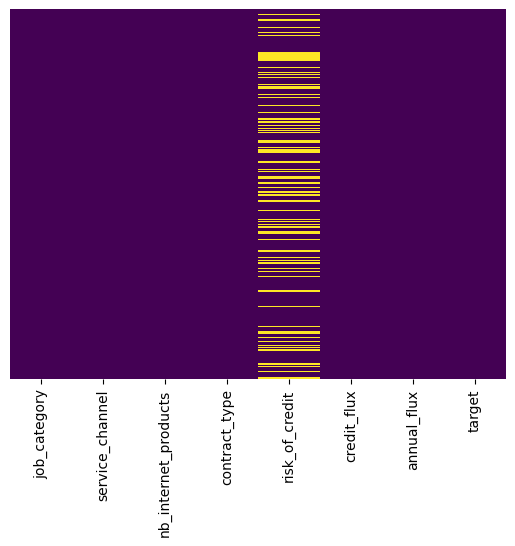

In [25]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Observons la dispersion des données de la colonne 'risk_of_credit'

<Axes: xlabel='risk_of_credit', ylabel='count'>

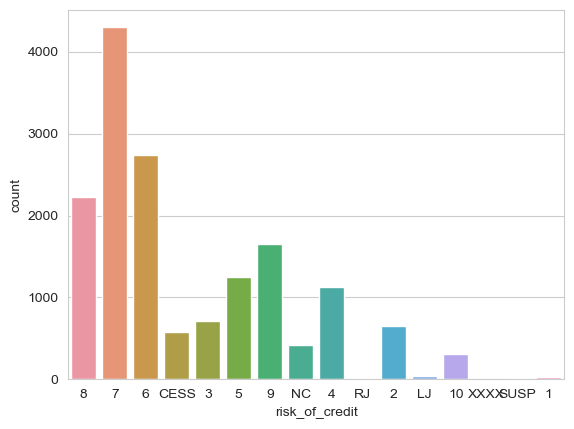

In [26]:
sns.set_style('whitegrid')
sns.countplot(x='risk_of_credit',data=df)

In [27]:
df['risk_of_credit'].isna().sum()

4767

J'étudie la corrélation entre les données afin de voir si je pourrais essayer de prédire les valeurs manquantes dans la colonne 'risk_of_credit'

Tout d'abord je transforme les données catégorielle du dataframe en données numériques


In [28]:
df['annual_flux']= df['annual_flux'].str.replace(',', '.', regex=True)

In [29]:
data= df.copy()

In [30]:
#get all categorical columns
cat_columns = ['job_category','service_channel','risk_of_credit','credit_flux']

#convert all categorical columns to numeric
data[cat_columns] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])

data = data.astype(float, errors = 'raise')

In [31]:
data

job_category  service_channel  nb_internet_products  contract_type  \
0               0.0              0.0                   2.0            1.0   
1               0.0              0.0                   1.0            1.0   
2               1.0              1.0                   1.0            1.0   
3               2.0              1.0                   0.0            1.0   
4               3.0              0.0                   2.0            1.0   
...             ...              ...                   ...            ...   
20823         373.0             10.0                   0.0            1.0   
20824           1.0              1.0                   1.0            1.0   
20825          37.0              0.0                   1.0            1.0   
20826         225.0             10.0                   0.0            2.0   
20827         197.0              7.0                   0.0            0.0   

       risk_of_credit  credit_flux  annual_flux  target  
0                 0.0          0.0     20903.81     0.0  
1                 1.0          0.0      5192.50     0.0  
2                 2.0          1.0         0.00     0.0  
3                 3.0          0.0        33.40     0.0  
4                 1.0          0.0     13910.00     0.0  
...               ...          ...          ...     ...  
20823             5.0          1.0         0.00     0.0  
20824             0.0          1.0         0.00     0.0  
20825             2.0          1.0         0.00     0.0  
20826             6.0          1.0         0.00     0.0  
20827             8.0          1.0         0.00     0.0  

[20828 rows x 8 columns]

<Axes: >

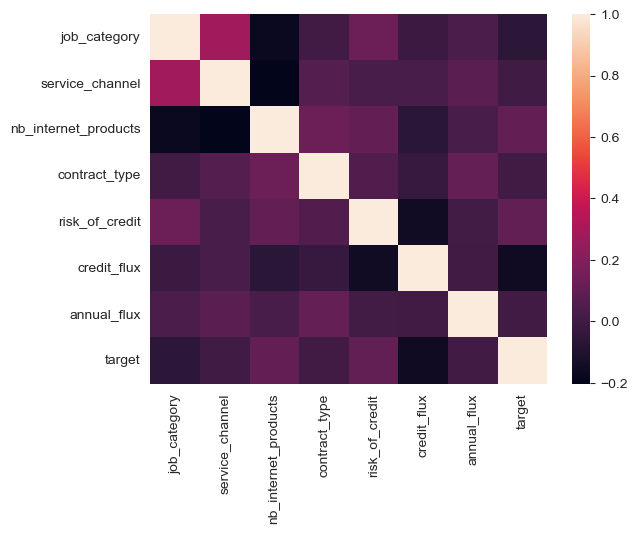

In [32]:
from scipy.stats import pearsonr
df_full = data.dropna(inplace=False)
sns.heatmap(df_full.corr(), xticklabels=df_full.columns, yticklabels=data.columns)

In [33]:
for value in df_full.columns:

    coeff_pearson,_ = pearsonr(df_full['risk_of_credit'],df_full[value])
    print("coefficient de Pearson = {}".format(coeff_pearson), value)

coefficient de Pearson = 0.129143611693395 job_category
coefficient de Pearson = 0.028362796317517317 service_channel
coefficient de Pearson = 0.10581805955139774 nb_internet_products
coefficient de Pearson = 0.04857364485140571 contract_type
coefficient de Pearson = 1.0 risk_of_credit
coefficient de Pearson = -0.15001744901985684 credit_flux
coefficient de Pearson = 0.009355874120609182 annual_flux
coefficient de Pearson = 0.09917768754369218 target


Une regression logistique ne serait déjà pas adaptée dans notre cas.
Je vais donc tout simplement procéder à une imputation.

In [34]:
data['risk_of_credit'].unique()

array([ 0.,  1.,  2.,  3.,  4., -1.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15.])

In [35]:
data["risk_of_credit"].fillna(float(-1), inplace = True) 

<Axes: xlabel='risk_of_credit', ylabel='count'>

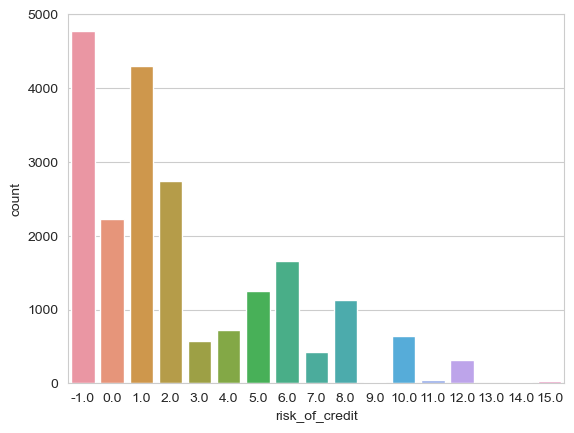

In [36]:
sns.set_style('whitegrid')
sns.countplot(x='risk_of_credit',data=data)

In [37]:
data.isna().sum()

job_category            0
service_channel         0
nb_internet_products    0
contract_type           0
risk_of_credit          0
credit_flux             0
annual_flux             0
target                  0
dtype: int64

In [38]:
#Essayons aussi avec 'target'

for value in df_full.columns:

    coeff_pearson,_ = pearsonr(df_full['target'],df_full[value])
    print("coefficient de Pearson = {}".format(coeff_pearson), value)

coefficient de Pearson = -0.05907917366758479 job_category
coefficient de Pearson = 7.976955127582397e-05 service_channel
coefficient de Pearson = 0.10628773274536785 nb_internet_products
coefficient de Pearson = 0.0078061324774281625 contract_type
coefficient de Pearson = 0.09917768754369218 risk_of_credit
coefficient de Pearson = -0.1527875559873421 credit_flux
coefficient de Pearson = 0.006170485898175125 annual_flux
coefficient de Pearson = 1.0 target


Par la suite pour pouvoir prédire target, je vais donc me pencher sur des modèles de random forest et decision tree

Essayons de prédire 'risk_of_credit'

In [39]:
#pip install scikit-plot

In [40]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, cross_val_predict
from scipy.stats import randint

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import scikitplot as skplt

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [41]:
X= df_full.drop(['risk_of_credit'],axis=1)

In [42]:
X

job_category  service_channel  nb_internet_products  contract_type  \
0               0.0              0.0                   2.0            1.0   
1               0.0              0.0                   1.0            1.0   
2               1.0              1.0                   1.0            1.0   
3               2.0              1.0                   0.0            1.0   
4               3.0              0.0                   2.0            1.0   
...             ...              ...                   ...            ...   
20823         373.0             10.0                   0.0            1.0   
20824           1.0              1.0                   1.0            1.0   
20825          37.0              0.0                   1.0            1.0   
20826         225.0             10.0                   0.0            2.0   
20827         197.0              7.0                   0.0            0.0   

       credit_flux  annual_flux  target  
0              0.0     20903.81     0.0  
1              0.0      5192.50     0.0  
2              1.0         0.00     0.0  
3              0.0        33.40     0.0  
4              0.0     13910.00     0.0  
...            ...          ...     ...  
20823          1.0         0.00     0.0  
20824          1.0         0.00     0.0  
20825          1.0         0.00     0.0  
20826          1.0         0.00     0.0  
20827          1.0         0.00     0.0  

[20828 rows x 7 columns]

In [43]:
Y= df_full["risk_of_credit"]

In [44]:
Y

0        0.0
1        1.0
2        2.0
3        3.0
4        1.0
        ... 
20823    5.0
20824    0.0
20825    2.0
20826    6.0
20827    8.0
Name: risk_of_credit, Length: 20828, dtype: float64

In [45]:
Y.unique()

array([ 0.,  1.,  2.,  3.,  4., -1.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15.])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [203]:
RFC = RandomForestClassifier(max_depth=14, n_estimators=127)
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, n_estimators=127)

In [204]:
pred = RFC.predict(X_test)

In [205]:
print (RFC.score(X_train,y_train))
print(RFC.score(X_test,y_test))

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

0.9583440034144259
0.9185867895545314
Accuracy: 0.9185867895545314


Au vu des resultats, je préfère remplacer les valeurs Nan par une nouvelle catégorie

In [50]:
df["risk_of_credit"].fillna('inconnu', inplace = True) 

In [51]:
#get all categorical columns
cat_columns = ['job_category','service_channel','risk_of_credit','credit_flux']

#convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

df = df.astype(float, errors = 'raise')

In [52]:
df.isna().sum()

job_category            0
service_channel         0
nb_internet_products    0
contract_type           0
risk_of_credit          0
credit_flux             0
annual_flux             0
target                  0
dtype: int64

In [53]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

train.to_csv('data/train.csv')
test.to_csv('data/test.csv')

In [54]:
X= train.drop(['target'],axis=1)
Y= train["target"]

In [55]:
x_test= test.drop(['target'],axis=1)
y= test["target"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# CONSTRUCTION DES MODELES

# Forêts aléatoire (Random Forest)

In [206]:
RFC = RandomForestClassifier(max_depth=14, n_estimators=127)
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, n_estimators=127)

In [207]:
pred = RFC.predict(X_test)

In [208]:
print (RFC.score(X_train,y_train))
print(RFC.score(X_test,y_test))

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

0.9581732821169441
0.9196108550947261
Accuracy: 0.9196108550947261


In [209]:
rfc_cv_score = cross_val_score(RFC, X, Y, cv=10, scoring='roc_auc')

In [210]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[3540   21]
 [ 293   52]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      3561
         1.0       0.71      0.15      0.25       345

    accuracy                           0.92      3906
   macro avg       0.82      0.57      0.60      3906
weighted avg       0.90      0.92      0.89      3906



=== All AUC Scores ===
[0.85269972 0.85625377 0.86495625 0.86406536 0.86313704 0.87054866
 0.88641502 0.83413189 0.85106383 0.89027805]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8633549595055469


In [211]:
predictions = cross_val_predict(RFC, X, Y, cv=10)

In [212]:
probas = RFC.predict_proba(X_test)

Fixons le seuil a 0.50 comme demandé

In [213]:
seuil= 0.5
prediction_new= []

for i in range(len(probas)):
    
    x= probas[i][0]
    
    if x>= seuil: 
        prediction_new.append(0.0)
        
    else: 
        prediction_new.append(1.0)

In [214]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, prediction_new))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, prediction_new))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[3540   21]
 [ 293   52]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      3561
         1.0       0.71      0.15      0.25       345

    accuracy                           0.92      3906
   macro avg       0.82      0.57      0.60      3906
weighted avg       0.90      0.92      0.89      3906



=== All AUC Scores ===
[0.85269972 0.85625377 0.86495625 0.86406536 0.86313704 0.87054866
 0.88641502 0.83413189 0.85106383 0.89027805]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8633549595055469


In [215]:
res= confusion_matrix(y_test, prediction_new)

Random Forest semble donner de bons résultats. Je vais donc garder les resultats obtenue avec un seuil de 0.5

In [151]:
##dump the model into a file
import pickle 
with open('output/modele.pickle', 'wb') as f_out:
    pickle.dump(RFC, f_out) # write final_model in .bin file
    f_out.close()  # close the file 


# AUTRE METHODE

# SMOTE

In [152]:
#pip install imbalanced-learn
#pip install scikit-learn==1.2.2

In [153]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [154]:
# define pipeline
model = RandomForestClassifier(max_depth=depth, n_estimators=estimators)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [155]:
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean

In [156]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.852


In [157]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 RandomForestClassifier(max_depth=15, n_estimators=160))])

In [158]:
pred = pipeline.predict(X_test)

In [159]:
print (pipeline.score(X_train,y_train))
print(pipeline.score(X_test,y_test))

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

0.8801536491677336
0.8317972350230415
Accuracy: 0.8317972350230415


In [160]:
rfc_cross_val_score = cross_val_score(pipeline, X, Y, cv=10, scoring='roc_auc')

In [161]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cross_val_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cross_val_score.mean())

=== Confusion Matrix ===
[[3032  529]
 [ 128  217]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      3561
         1.0       0.29      0.63      0.40       345

    accuracy                           0.83      3906
   macro avg       0.63      0.74      0.65      3906
weighted avg       0.90      0.83      0.86      3906



=== All AUC Scores ===
[0.84723344 0.83903205 0.85169769 0.85000574 0.84439087 0.865373
 0.87247019 0.83404205 0.84267896 0.87720914]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.852413314036729


Jusqu'ici les resultats semblent moins bons. 

# PREDICTIONS

In [163]:
# load the model from disk
model = pickle.load(open('output/modele.pickle', 'rb'))
model

RandomForestClassifier(max_depth=15, n_estimators=127)

In [164]:
predictions= model.predict(x_test)

In [165]:
acc= accuracy_score(y, predictions)
print("Accuracy:", acc)

Accuracy: 0.9220280391780296


In [166]:
confusion_matrix(y, predictions)

array([[4718,   46],
       [ 360,   83]], dtype=int64)

In [167]:
prob = model.predict_proba(x_test)

In [168]:
seuil= 0.5
new_predictions = []

for i in range(len(prob)):
    
    x= prob[i][0]
    
    if x>= seuil: 
        new_predictions.append(0.0)
        
    else: 
        new_predictions.append(1.0)
    

In [169]:
matrix_threshold= confusion_matrix(y, new_predictions)
matrix_threshold

array([[4718,   46],
       [ 360,   83]], dtype=int64)

In [170]:
print("=== Classification Report ===")
print(classification_report(y, new_predictions))

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      4764
         1.0       0.64      0.19      0.29       443

    accuracy                           0.92      5207
   macro avg       0.79      0.59      0.62      5207
weighted avg       0.90      0.92      0.90      5207



In [171]:
p = pd.DataFrame(matrix_threshold, columns=['0', '1'])
p.to_csv('output/confusion_matrix.csv')

In [172]:
f= pd.DataFrame(columns=['initial_target', 'predicted_target'], index=range(len(y)))
f['initial_target']= y.values.reshape(len(y))
f['predicted_target']= np.array(new_predictions)
f

initial_target  predicted_target
0                0.0               0.0
1                0.0               0.0
2                0.0               0.0
3                0.0               0.0
4                0.0               0.0
...              ...               ...
5202             0.0               0.0
5203             0.0               0.0
5204             0.0               0.0
5205             0.0               0.0
5206             0.0               0.0

[5207 rows x 2 columns]

In [173]:
f.to_csv('output/predictions.csv')

# APPRENTISSAGE EN UTILISANT L'ENSEMBLE DU JEU DE DONNEES

In [174]:
X1= df.drop(['target'],axis=1)
Y1= df["target"]

In [175]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.25, random_state=42)

In [195]:
RFC1 = RandomForestClassifier(max_depth=14, n_estimators=127)
RFC1.fit(X_train1, y_train1)

RandomForestClassifier(max_depth=14, n_estimators=127)

In [196]:
pred1 = RFC.predict(X_test1)

In [197]:
print (RFC.score(X_train1,y_train1))
print(RFC.score(X_test1,y_test1))

accuracy1 = accuracy_score(y_test1, pred1)
print("Accuracy:", accuracy1)

0.955636642980603
0.9220280391780296
Accuracy: 0.9220280391780296


In [198]:
rfc_cv_score1 = cross_val_score(RFC1, X1, Y1, cv=10, scoring='roc_auc')

In [199]:
probas1 = RFC1.predict_proba(X_test1)

In [200]:
seuil= 0.5
prediction_new1= []

for i in range(len(probas1)):
    
    x= probas1[i][0]
    
    if x>= seuil: 
        prediction_new1.append(0.0)
        
    else: 
        prediction_new1.append(1.0)
    

In [201]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test1, prediction_new1))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test1, prediction_new1))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score1)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score1.mean())

=== Confusion Matrix ===
[[4738   26]
 [ 376   67]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      4764
         1.0       0.72      0.15      0.25       443

    accuracy                           0.92      5207
   macro avg       0.82      0.57      0.60      5207
weighted avg       0.91      0.92      0.90      5207



=== All AUC Scores ===
[0.83226725 0.85401276 0.8603409  0.86150856 0.84630052 0.85970011
 0.88424706 0.85857693 0.86036986 0.87952243]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8596846368621254


Resultats avant

In [202]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, prediction_new))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, prediction_new))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[3531   30]
 [ 289   56]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      3561
         1.0       0.65      0.16      0.26       345

    accuracy                           0.92      3906
   macro avg       0.79      0.58      0.61      3906
weighted avg       0.90      0.92      0.90      3906



=== All AUC Scores ===
[0.85161744 0.85292847 0.85881983 0.86752412 0.86067897 0.86507853
 0.8839894  0.82980969 0.8497487  0.88665708]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8606852248253084


Avec un jeu de données plus grand, on aurait obtenu de meilleurs résultats